In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''

'This script demonstrates how to build a variational autoencoder with Keras.\n #Reference\n - Auto-Encoding Variational Bayes\n   https://arxiv.org/abs/1312.6114\n'

# Build an autoencoder

In [2]:
from __future__ import print_function                           # import a bunch of functions

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0                                               # epsilon are the noise added????????????

In [4]:
x = Input(shape=(original_dim,))                                # x=Input(shape=(784,))
h = Dense(intermediate_dim, activation='relu')(x)               # h=Dense(256,activation='relu')(x)     #(x as the input)
z_mean = Dense(latent_dim)(h)                                   # z_mean=Dense(2)(h)
z_log_var = Dense(latent_dim)(h)                                # z_log_var=Dense(2)(h)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
def sampling(args):                                             # is z_mean, z_log_var representing noises to add?
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev= 1) 
    # Keras.backend = K, ask it to epsilon=(generate) random_normal(shape=K.shape(z_mean)[0], 2), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon              # epsilon is the noise to add. this return the noisy data

In [11]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])   # Lambda is a function to transform data from the input [z_mean, z_log_var]
                                                                # z is the noised bottleneck layer.
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')          # h is coder, decoder_h is mirror of h, it seems same as h.
decoder_mean = Dense(original_dim, activation='sigmoid')        # decoder_mean are the last layer, that recaptulate the orignial dimension.
h_decoded = decoder_h(z)                                        # h_decoded is the result of of the second last layer.
x_decoded_mean = decoder_mean(h_decoded)                        # x_decoded_mean is the result produced.

In [12]:
# instantiate VAE model
vae = Model(x, x_decoded_mean)                                  # with all the layers, function, and variables included, now instantiate the model
                                                                # ????? this seems not involving layers. does it work like a snakemake, to trace all the layers and parameters??????
# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)               # reconstruction loss using keras.metrics.binary_crossentropy(x, x_decoded_mean)
                                                                                        # intuitive understanding of cross entropy for binary classification, refer to https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)   # intuitive understanding of this KL divergence refer to
                                                                                        # https://forums.fast.ai/t/intuition-behind-kl-divergence-regularization-in-vaes/1650
vae_loss = K.mean(xent_loss + kl_loss)                          # an average of the two loss function is used.

In [13]:
vae.add_loss(vae_loss)                  # add the loss function to the model
vae.compile(optimizer='rmsprop')        # add optimizer method to the model to compile.
vae.summary()                           # ????? what is the summary about?

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [15]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()        # ????? load data ? how can it load to different parameters ???

x_train = x_train.astype('float32') / 255.                      # ?????? this is to convert to certain type. ???? why 255?
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))   # ?????
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))   # ????? what does this mean?

In [16]:
vae.fit(x_train,                                                # fit the vae model using x_train
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 63us/step - loss: 166.2063 - val_loss: 165.3432
Epoch 2/50
60000/60000 [==============================] - 4s 62us/step - loss: 164.2696 - val_loss: 163.5164
Epoch 3/50
60000/60000 [==============================] - 4s 62us/step - loss: 162.8248 - val_loss: 162.2677
Epoch 4/50
60000/60000 [==============================] - 4s 62us/step - loss: 161.6511 - val_loss: 161.5978
Epoch 5/50
60000/60000 [==============================] - 4s 62us/step - loss: 160.5488 - val_loss: 160.2026
Epoch 6/50
60000/60000 [==============================] - 4s 62us/step - loss: 159.5227 - val_loss: 159.3784
Epoch 7/50
60000/60000 [==============================] - 4s 62us/step - loss: 158.6142 - val_loss: 158.9891
Epoch 8/50
60000/60000 [==============================] - 4s 62us/step - loss: 157.8401 - val_loss: 157.9738
Epoch 9/50
60000/60000 [==============================] - 4s 62us/step - loss:

In [17]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)                                      # name the encoder

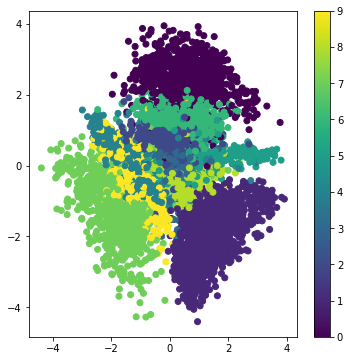

In [18]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size) # get the encoded x of the x_test  in 2 demension.
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)   #?????? why c= y_test?
plt.colorbar()                                                  # add the color bar
plt.show()                                                      # ??????? is this to show the plot?

# build a digit generator that can generate the learned distribution

In [19]:
decoder_input = Input(shape=(latent_dim,))                      # the shape of the decoder's input, a placeholder
_h_decoded = decoder_h(decoder_input)                           # ????????????? h_decoded, why do this again with a a _name variable?
#h_decoded = decoder_h(z)                                        # h_decoded is the result of of the second last layer.
#x_decoded_mean = decoder_mean(h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)               # here is something new, to generate a generator.

In [20]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits                              # there are 15 digits to be put in.
digit_size = 28                                                 # each image is 28x28 matrix
figure = np.zeros((digit_size * n, digit_size * n))             # fill in with 0s
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))                   # np.linspace: Return evenly spaced numbers over a specified interval.
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):                                 #
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])                         # generate a set of 2 float numbers.
        x_decoded = generator.predict(z_sample)                 # use generator to convert the float numers back to graph.
        digit = x_decoded[0].reshape(digit_size, digit_size)    # reshape the graph as the 2 dimensional matrix named as digit.
        figure[i * digit_size: (i + 1) * digit_size,            # now put the digit to the parameters of the figures.
               j * digit_size: (j + 1) * digit_size] = digit

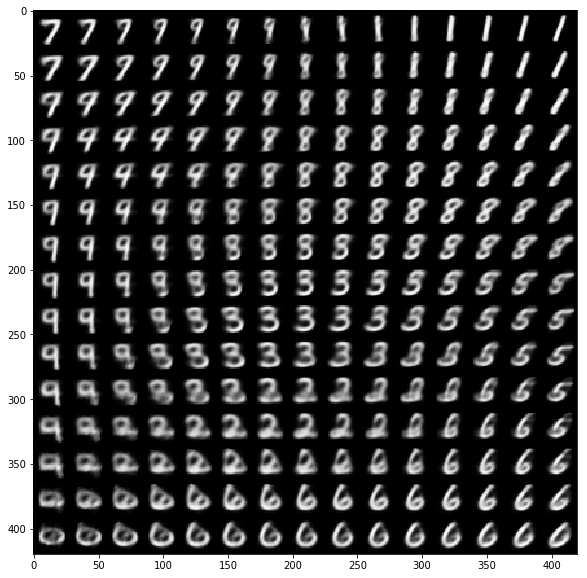

In [21]:
plt.figure(figsize=(10, 10))                                    # fix the canvas
plt.imshow(figure, cmap='Greys_r')                              # plot the figure.
plt.show()